# Dark diversity extended simulations

This notebook is an extension of the initial dark diversity simulation experiments. 

This simulation extends on the previous by considering more species and more diverse species distributions, to get a more complex network of species co-occurrences.

In [2]:
library(ggplot2)
library(terra)
library(tidyr)
library(dplyr)
library(DarkDiv)
library(gamm4)
set.seed(123)

terra 1.8.29


Attaching package: 'tidyr'


The following object is masked from 'package:terra':

    extract



Attaching package: 'dplyr'


The following objects are masked from 'package:terra':

    intersect, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loading required package: lme4

Loading required package: mgcv

Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:lme4':

    lmList


The following object is masked from 'package:dplyr':

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

This is gamm4 0.2-6




# 1. Generating the environmental variables

Environmental variables for species distributions as well as drivers of dark diversity are generated as before, however this time we consider up to 6 environmental variables for species distributions, instead of 2 previously. We also have 3 different drivers of dark diversity, instead of 1 previously.

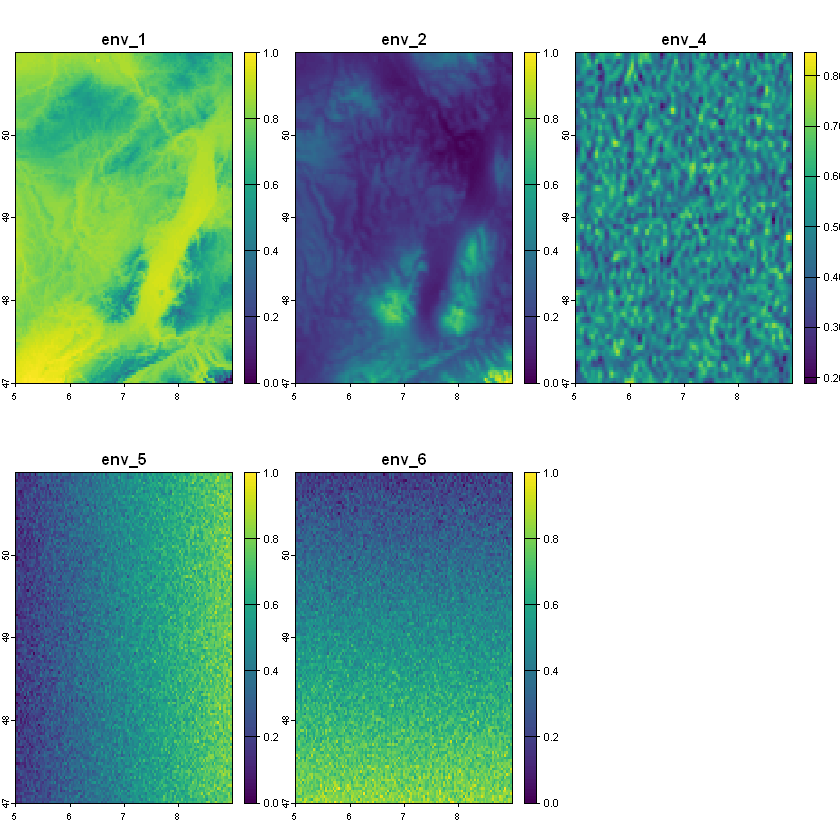

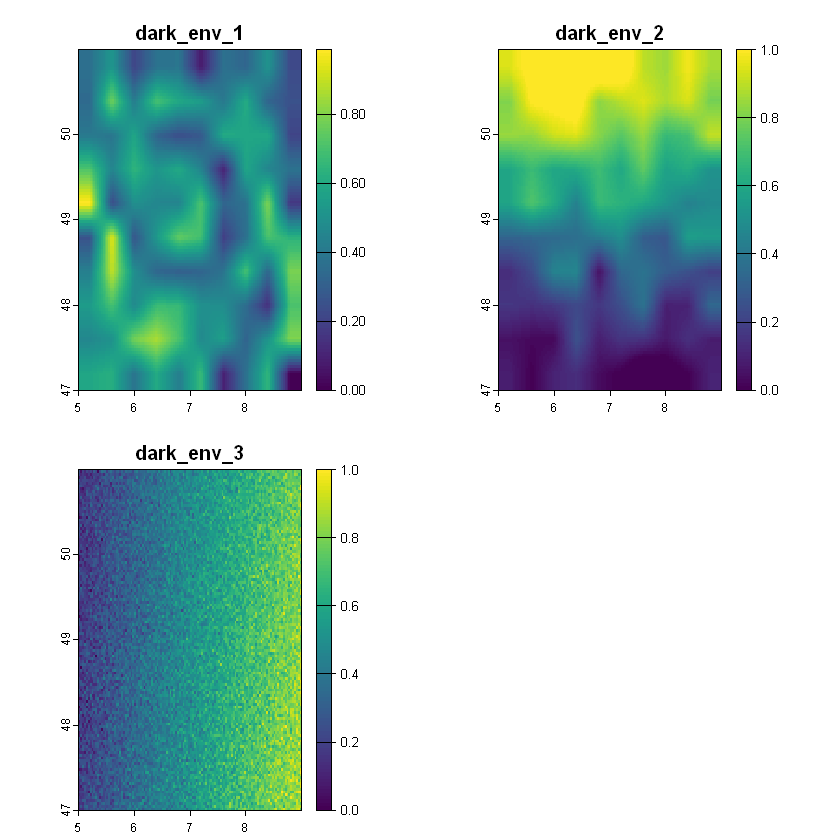

In [3]:
par(bg = "white")  # Set the background color and layout
# This uses cropped data from CHELSA bio1 and bio12 for central Europe
env_1 <- terra::rast("sim_data_chelsa\\bio1.tif") |> terra::aggregate(4)
values(env_1) <- scales::rescale(values(env_1))
env_2 <- terra::rast("sim_data_chelsa\\bio12.tif") |> terra::aggregate(4)
values(env_2) <- scales::rescale(values(env_2))

# Simulated environmental data
## Simulated factor data
env_3 <- terra::rast(terra::ext(env_1), nrows = nrow(env_1), ncols = ncol(env_1)) |>
    terra::aggregate(8)
values(env_3) <- round(runif(n = ncell(env_3), min = 0, max = 5))
env_3 <- terra::disagg(env_3, 8)

## Random normal data
env_4 <- terra::rast(terra::ext(env_1), nrows = nrow(env_1), ncols = ncol(env_1)) |>
    terra::aggregate(2)
values(env_4) <- rnorm(n = ncell(env_4), mean = 0, sd = 1) |>
    scales::rescale()
env_4 <- terra::resample(env_4, env_1)

## Gradient along x axis
env_5 <- terra::rast(terra::ext(env_1), nrows = nrow(env_1), ncols = ncol(env_1))
values(env_5) <- rep(
    seq(0, 10, length.out = nrow(env_1)), ncol(env_1)
) + rnorm(n = ncell(env_5), mean = 0, sd = 1)
values(env_5) <- values(env_5) |> scales::rescale()

## Gradient along y axis
env_6 <- terra::rast(terra::ext(env_1), nrows = nrow(env_1), ncols = ncol(env_1))
values(env_6) <- rep(
    seq(0, 10, length.out = ncol(env_6)),
    each = nrow(env_6)
) + rnorm(n = ncell(env_6), mean = 0, sd = 1)
values(env_6) <- values(env_6) |> scales::rescale()

envs <- c(
    env_1,
    env_2,
    # env_3,
    env_4,
    env_5,
    env_6
)

names(envs) <- c(
    "env_1",
    "env_2",
    # "env_3",
    "env_4",
    "env_5",
    "env_6"
)

# Now generate the dark diversity covariates
dark_env_1 <- terra::rast(
    terra::ext(env_1)
)
values(dark_env_1) <- rnorm(n = ncell(dark_env_1), mean = 0, sd = 1) |>
    scales::rescale()
dark_env_1 <- terra::resample(dark_env_1, env_1) |> terra::clamp(0, 1)

dark_env_2 <- terra::rast(
    terra::ext(env_1)
)
values(dark_env_2) <- rep(
    seq(1, 0, length.out = ncol(dark_env_2)),
    each = nrow(dark_env_2)
) + rnorm(n = ncell(dark_env_2), mean = 0, sd = 0.1)
dark_env_2 <- terra::resample(dark_env_2, env_1) |> terra::clamp(0, 1)

dark_env_3 <- env_5 * (env_6 + 5)
values(dark_env_3) <- values(dark_env_3) |> scales::rescale()
dark_env_3 <- terra::clamp(dark_env_3, 0, 1)

dark_envs <- c(
    dark_env_1,
    dark_env_2,
    dark_env_3
)

names(dark_envs) <- c(
    "dark_env_1",
    "dark_env_2",
    "dark_env_3"
)

plot(envs)
plot(dark_envs)

# 2. Generating species distributions

Using the 6 generated environmental variables, I will use the `virtualspecies` R package to generate a set of species distributions. This applies a gaussian/normal function to each of the environmental variables to generate a species distribution for each species.

A total of 25 species distributions will be generated, instead of only 3 previously. This will result in a more complex network of species co-occurrences, that should better predict dark diversity across the study area.


In [4]:
library(virtualspecies)

par(bg = "white")  # Set the background color and layout

n_species <- 25

sp_dists <- list()
for (i in 1:n_species) {
    sp_parameters <- virtualspecies::formatFunctions(
        env_1 = c(fun = "dnorm", mean = runif(1, min = minmax(env_1)[1], max = minmax(env_1)[2]), sd = runif(1, min = 0.1, max = 0.5)),
        env_2 = c(fun = "dnorm", mean = runif(1, min = minmax(env_2)[1], max = minmax(env_2)[2]), sd = runif(1, min = 0.1, max = 0.5)),
        env_4 = c(fun = "dnorm", mean = runif(1, min = minmax(env_4)[1], max = minmax(env_4)[2]), sd = runif(1, min = 0.1, max = 0.5)),
        env_5 = c(fun = "dnorm", mean = runif(1, min = minmax(env_5)[1], max = minmax(env_5)[2]), sd = runif(1, min = 0.1, max = 0.5)),
        env_6 = c(fun = "dnorm", mean = runif(1, min = minmax(env_6)[1], max = minmax(env_6)[2]), sd = runif(1, min = 0.1, max = 0.5)),
    )
    sp_dists[[i]] <- virtualspecies::generateSpFromFun(
        raster.stack = envs[[c("env_1", "env_2", "env_4", "env_5", "env_6")]],
        parameters = sp_parameters
    )
}

Generating virtual species environmental suitability...


 - The response to each variable was rescaled between 0 and 1. To
            disable, set argument rescale.each.response = FALSE


 - The final environmental suitability was rescaled between 0 and 1. To disable, set argument rescale = FALSE


Generating virtual species environmental suitability...


 - The response to each variable was rescaled between 0 and 1. To
            disable, set argument rescale.each.response = FALSE


 - The final environmental suitability was rescaled between 0 and 1. To disable, set argument rescale = FALSE


Generating virtual species environmental suitability...


 - The response to each variable was rescaled between 0 and 1. To
            disable, set argument rescale.each.response = FALSE


 - The final environmental suitability was rescaled between 0 and 1. To disable, set argument rescale = FALSE


Generating virtual species environmental suitability...


 - The response to each variable was

class       : SpatRaster 
dimensions  : 120, 120, 25  (nrow, ncol, nlyr)
resolution  : 0.03333333, 0.03333333  (x, y)
extent      : 4.99986, 8.99986, 46.99986, 50.99986  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source(s)   : memory
names       : species_1, species_2, species_3, species_4, species_5, species_6, ... 
min values  :         0,         0,         0,         0,         0,         0, ... 
max values  :         1,         1,         1,         1,         1,         1, ... 

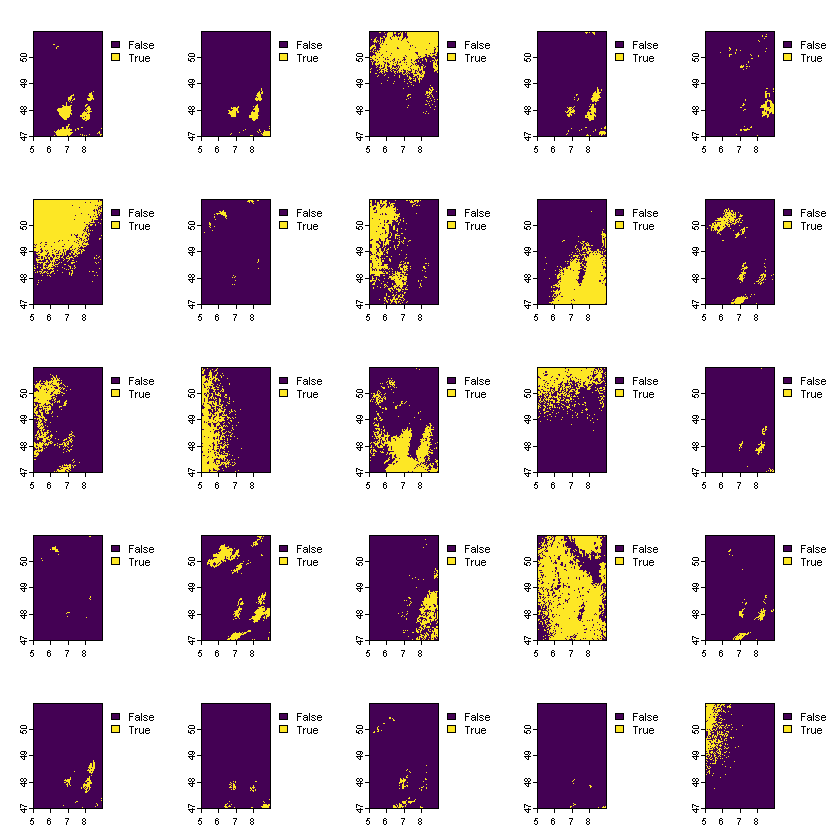

In [5]:
par(bg = "white", mfrow = c(5,5))  # Set the background color and layout

threshold <- 0.1

for (i in 1:length(sp_dists)) {
    plot(sp_dists[[i]]$suitab.raster > threshold)
}

dist_list<- c()
for (i in 1:length(sp_dists)) {
    dist_list <- c(dist_list, sp_dists[[i]]$suitab.raster)
}
dist_stack <- terra::rast(dist_list)
names(dist_stack) <- paste0("species_", 1:length(sp_dists))

dist_stack

Now we have the presence absence rasters of 25 generated species. We can then apply the dark diversity covariates to each species to generate the modified distribution. To keep it simple, it will be the application of one covariate for each species, with some species having none applied. 

We assume that in the absense of any driver of dark diversity, each species fully occupies its potential distribution, i.e. no species is in the dark diversity. 

The probability a species is in the dark diversity is calculated as:

`true probability x (1 - observed probability)`

The justification for this calculation is that the probability of a species being in the dark diversity is highest where the true and observed probabilities are most different. Where the true and observed probabilities are the same, the probability of a species being in the dark diversity is lower. This includes where the species is absent (true and observed probabilities are both low), and where the species is present (true and observed probabilities are both high), given that dark diversity is by definition where the species is not observed.


In [6]:
# Define which species is affect by which dark diversity covariate
dark_cov_applied <- sample(0:3, n_species, replace = TRUE)
# 0 = none, 1 = dark_env_1, 2 = dark_env_2, 3 = dark_env_3
# dark_cov_applied
dark_cov_df <- data.frame(species = paste0("species_", seq(1, n_species)), dark_cov_applied)
dark_cov_df

# Now apply the dark diversity covariates
dark_dist_list <- c()
for (i in 1:n_species) {
    if (dark_cov_applied[i] == 0) {
        dark_dist_list <- c(dark_dist_list, dist_stack[[i]])
    } else {
        dark_dist_list <- c(dark_dist_list, dist_stack[[i]] * dark_envs[[dark_cov_applied[i]]])
    }
}
dark_dist_stack <- terra::rast(dark_dist_list)

species,dark_cov_applied
<chr>,<int>
species_1,3
species_2,3
species_3,2
species_4,2
species_5,0
species_6,3
species_7,0
species_8,3
species_9,3


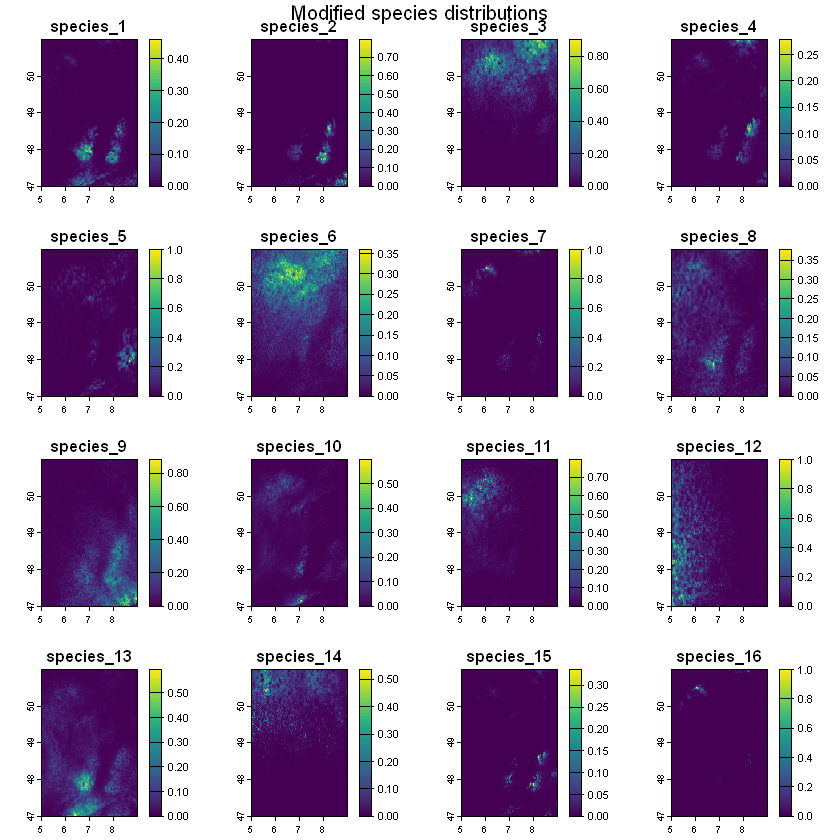

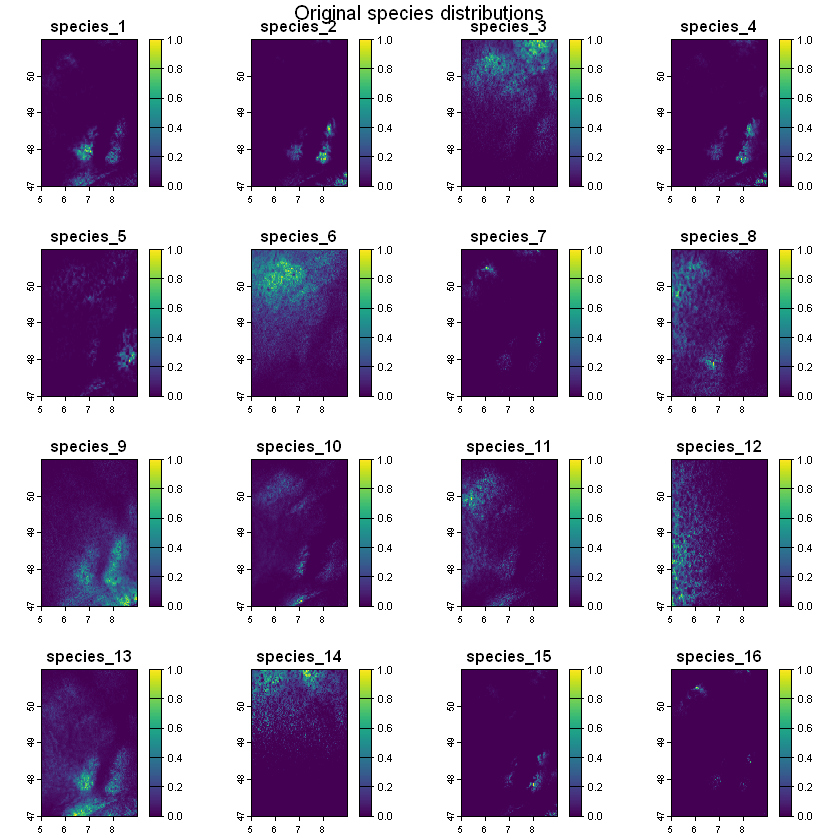

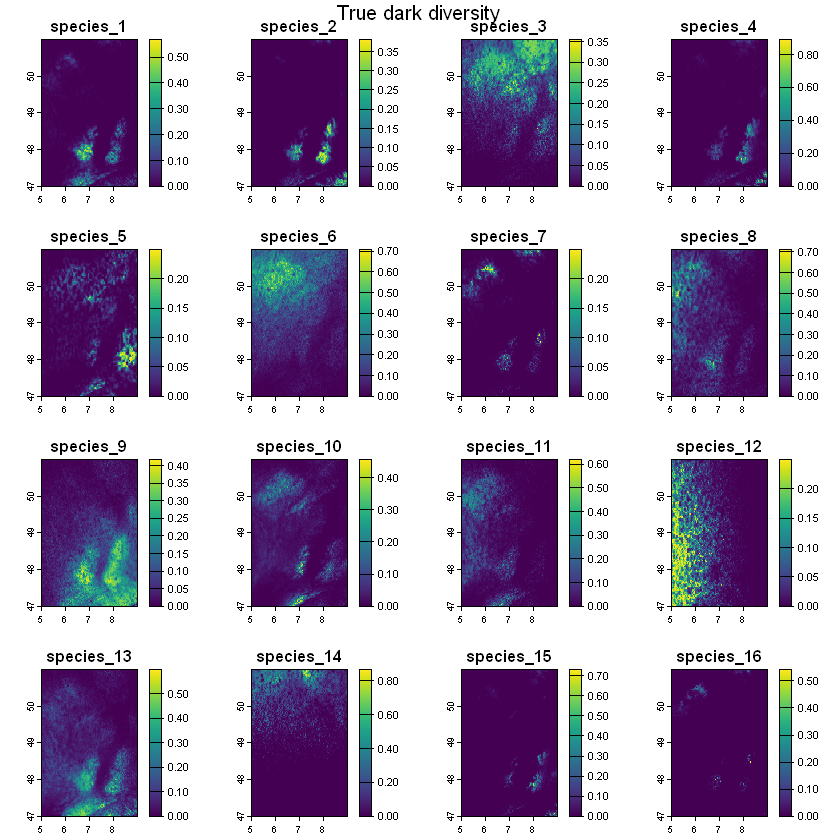

In [7]:
par(bg = "white")  # Set the background color and layout
plot(dark_dist_stack)
mtext("Modified species distributions", line = -1, outer = TRUE)

plot(dist_stack)
mtext("Original species distributions", line = -1, outer = TRUE)

true_dark_div <- dist_stack * (1 - dark_dist_stack)
par(bg = "white")
plot(true_dark_div)
mtext("True dark diversity", line = -1, outer = TRUE)

# 3. Sampling the study area

Identically to the previous simulation, a set of points will be sampled across the site, from which presence/absence for the species will be obtained. The dark diversity will be calculated for each species at each point.

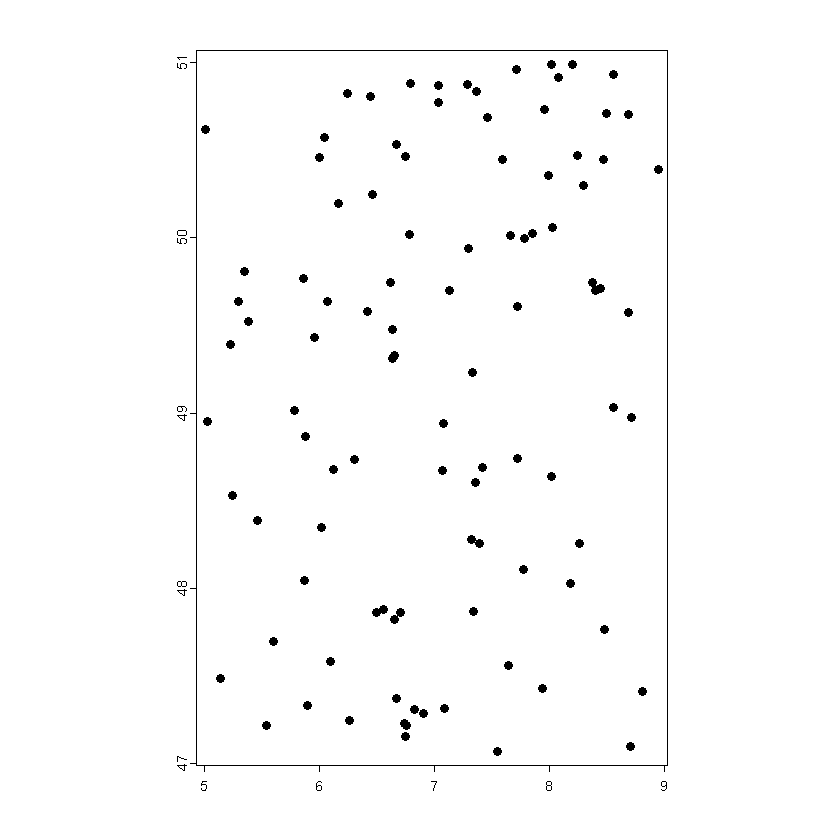

In [8]:
all_plots <- data.frame(
    x = runif(100000, ext(env_1)[1], ext(env_1)[2]),
    y = runif(100000, ext(env_1)[3], ext(env_1)[4])
) |> terra::vect(geom = c("x", "y"))


# Number of plots to use so we can easily change it
n_plots <- 100

plots <- sample(all_plots, n_plots)

par(bg = "white")
plot(plots)

In [9]:
observations <- terra::extract(dark_dist_stack, plots)[,-1] > threshold
head(observations)

species_1,species_2,species_3,species_4,species_5,species_6,species_7,species_8,species_9,species_10,⋯,species_16,species_17,species_18,species_19,species_20,species_21,species_22,species_23,species_24,species_25
FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,⋯,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


# 4. Calculating the dark diversity

Using the `DarkDiv` package, the dark diversity across each point is calculated using the hypergeometric method. This returns a probability value for each species at each point based on the co-occurrences of other species. 

Where no species is present, the probability returned is defined to be exactly 0, though originally the package returns `NaN`. 

Where the species is observed, the dark diversity probability is by definition 0, as the species is observed, and so the function returns `NA`. We leave this `NA` as is.

In [10]:
dd <- DarkDiv::DarkDiv(observations)
dark_div <- dd$Dark
dark_div_zerofilled <- ifelse(is.nan(dark_div), 0, dark_div)

head(dark_div_zerofilled)


Warning message in dataPrep(x = x, r = r, removeAbsent = removeAbsent):
"r included 5 species with zero occurrences.
                  
They have been removed from both r and x"


species_1,species_2,species_3,species_4,species_5,species_6,species_7,species_8,species_9,species_10,species_11,species_12,species_13,species_14,species_16,species_17,species_18,species_19,species_21,species_23
0.99947745,NA,0.012399787,0.3739428,0.3238779,0.01602958,0.2869079,0.9703483,NA,0.3739428,0.2095440,0.054900642,0.98178759,0.15726091,0.3739428,0.82395207,0.9703483,0.065802657,0.9999966,0.3739428
0.00000000,0.0000000,0.000000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.000000000,0.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.0000000,0.00000000,0.0000000,0.000000000,0.0000000,0.0000000
0.12219221,0.2794871,NA,NA,0.6648062,NA,NA,0.2558033,0.037315281,0.7439373,0.8771690,0.054489646,0.06981957,0.98835308,NA,0.75814928,0.2558033,NA,0.3404934,0.3404934
0.05884477,0.2386334,0.001525999,0.3085375,0.2386334,0.01194408,0.1908120,0.1549326,0.006432791,0.3085375,0.7989652,NA,0.11831738,0.05884477,0.3085375,0.06775421,0.1549326,0.005859343,0.3085375,0.3085375
0.06527594,0.1538158,0.999999994,0.9182296,0.6844204,0.99964794,0.9926146,0.3497958,0.022999683,0.9182296,0.9584962,0.005859343,0.01633976,0.99985591,0.9182296,0.81428047,0.3497958,NA,0.2364586,0.2364586
0.00000000,0.0000000,0.000000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.000000000,0.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.0000000,0.00000000,0.0000000,0.000000000,0.0000000,0.0000000


# 5. Spatially interpolating dark diversity

From the previous simulation, we found that using a GAM model to interpolate the dark diversity across the study area was the most effective method. We will use this method again to interpolate the dark diversity across the study area.



In [11]:
env_data <- terra::extract(envs, plots)[, -1]

full_obs <- cbind(dark_div_zerofilled, env_data)

head(full_obs)

,species_1,species_2,species_3,species_4,species_5,species_6,species_7,species_8,species_9,species_10,⋯,species_17,species_18,species_19,species_21,species_23,env_1,env_2,env_4,env_5,env_6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.99947745,NA,0.012399787,0.3739428,0.3238779,0.01602958,0.2869079,0.9703483,NA,0.3739428,⋯,0.82395207,0.9703483,0.065802657,0.9999966,0.3739428,0.4195933,0.88952356,0.4364108,0.7672373,0.7823880
2,0.00000000,0.0000000,0.000000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.000000000,0.0000000,⋯,0.00000000,0.0000000,0.000000000,0.0000000,0.0000000,0.8163894,0.16605263,0.5204712,0.7264037,0.4497433
3,0.12219221,0.2794871,NA,NA,0.6648062,NA,NA,0.2558033,0.037315281,0.7439373,⋯,0.75814928,0.2558033,NA,0.3404934,0.3404934,0.5261861,0.44395796,0.4806099,0.7324864,0.1516619
4,0.05884477,0.2386334,0.001525999,0.3085375,0.2386334,0.01194408,0.1908120,0.1549326,0.006432791,0.3085375,⋯,0.06775421,0.1549326,0.005859343,0.3085375,0.3085375,0.8398028,0.18038132,0.5623451,0.2734748,0.6016125
5,0.06527594,0.1538158,0.999999994,0.9182296,0.6844204,0.99964794,0.9926146,0.3497958,0.022999683,0.9182296,⋯,0.81428047,0.3497958,NA,0.2364586,0.2364586,0.7831177,0.17112218,0.5953763,0.5005703,0.4401857
6,0.00000000,0.0000000,0.000000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.000000000,0.0000000,⋯,0.00000000,0.0000000,0.000000000,0.0000000,0.0000000,0.8847812,0.03421408,0.3979081,0.6039420,0.3820333


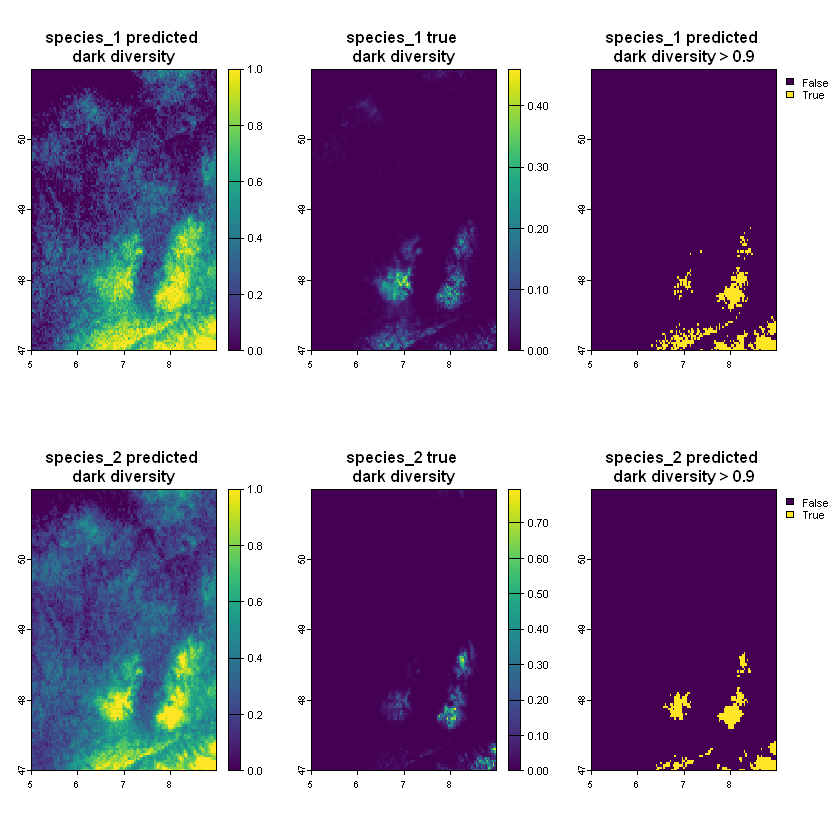

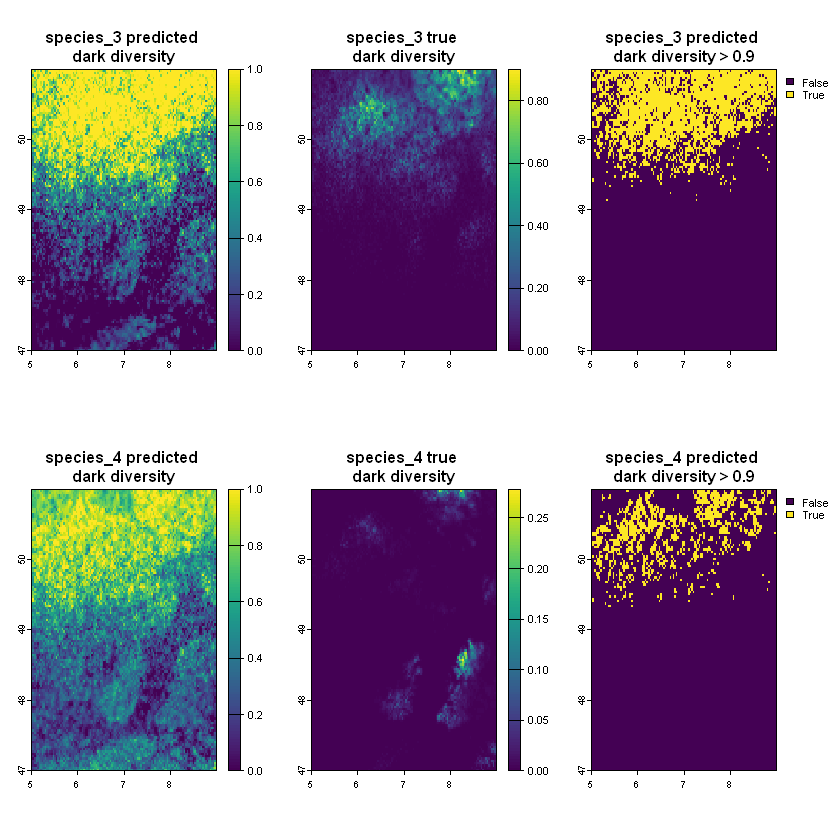

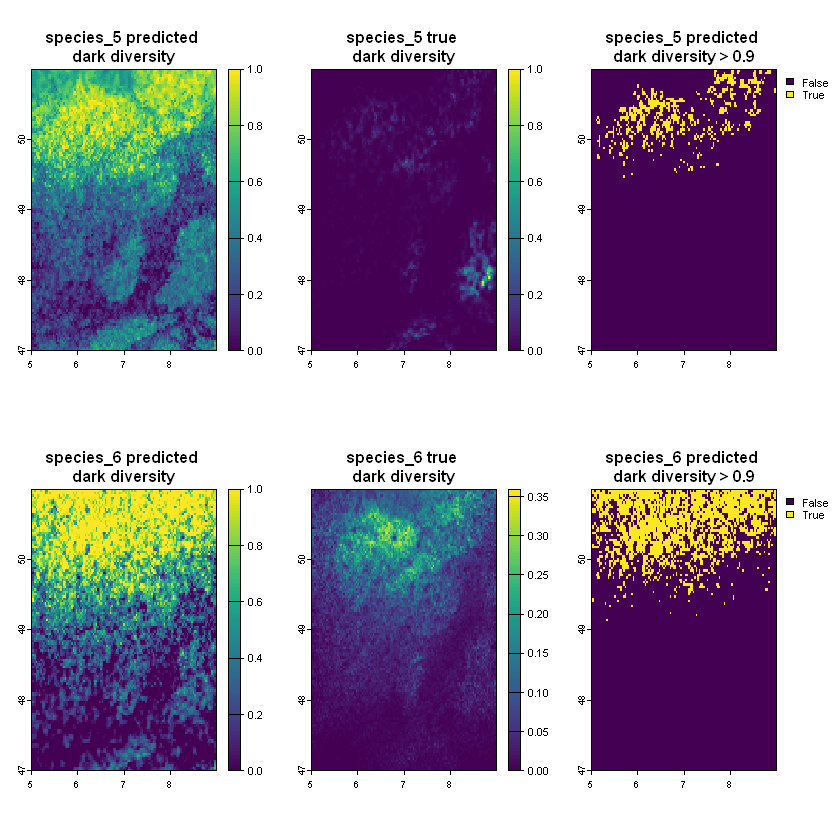

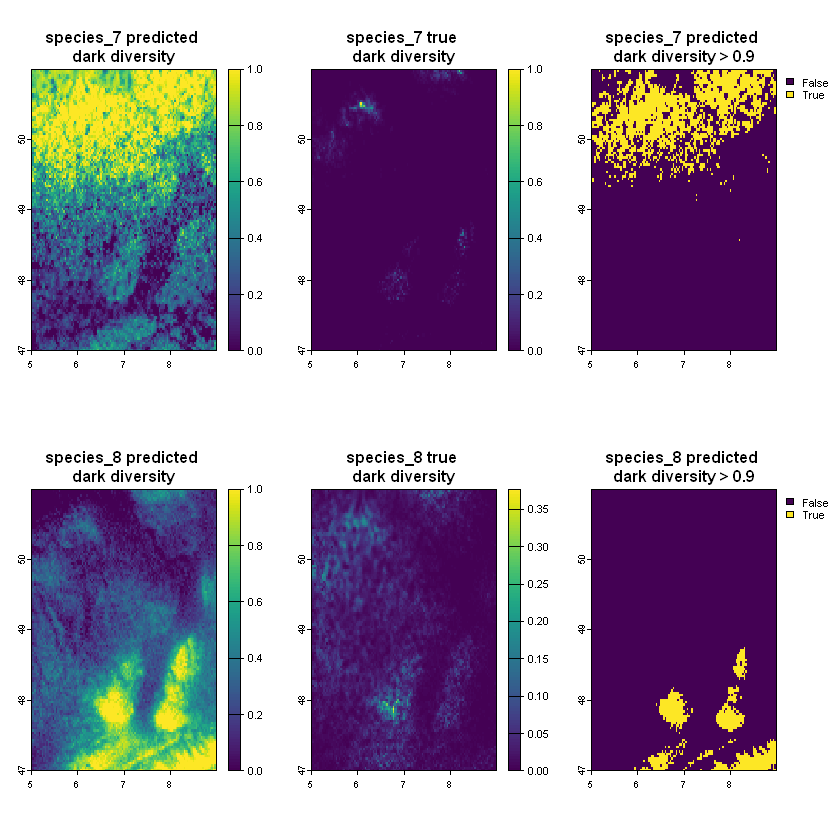

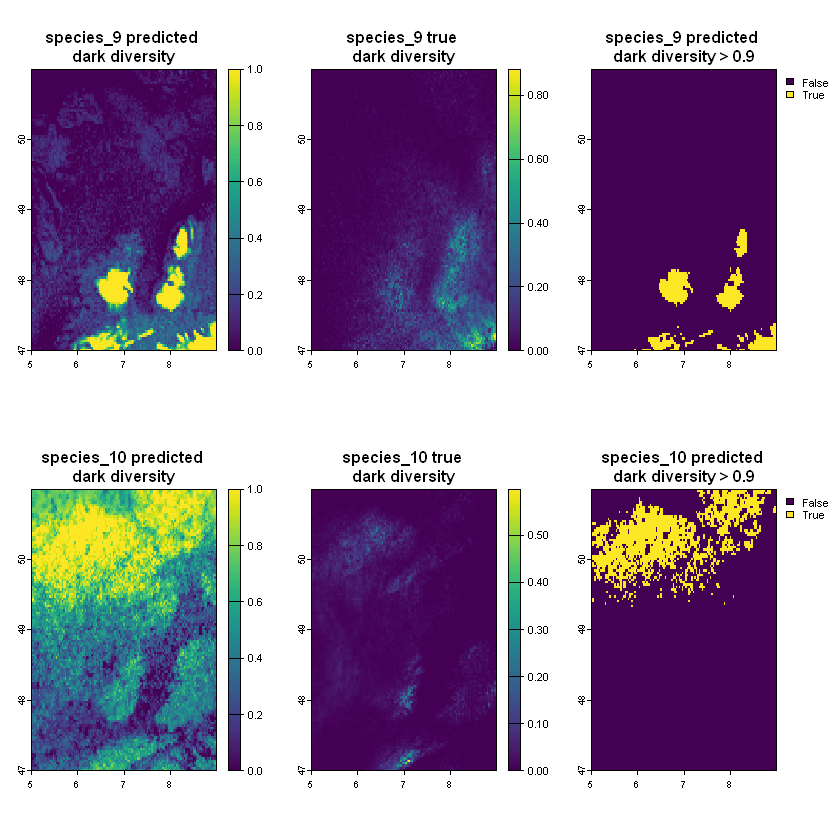

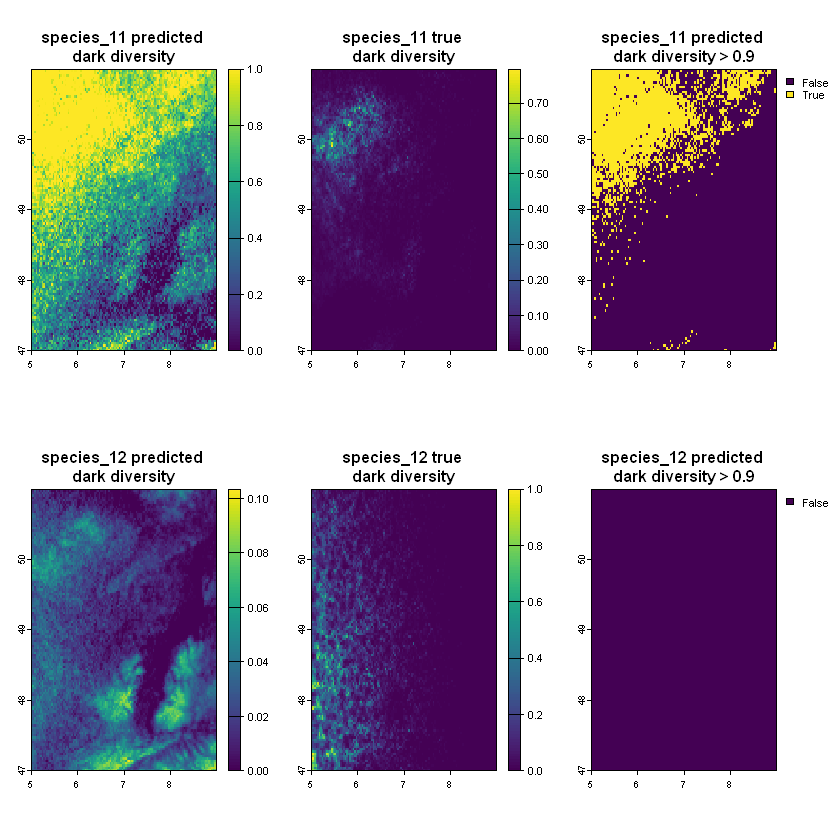

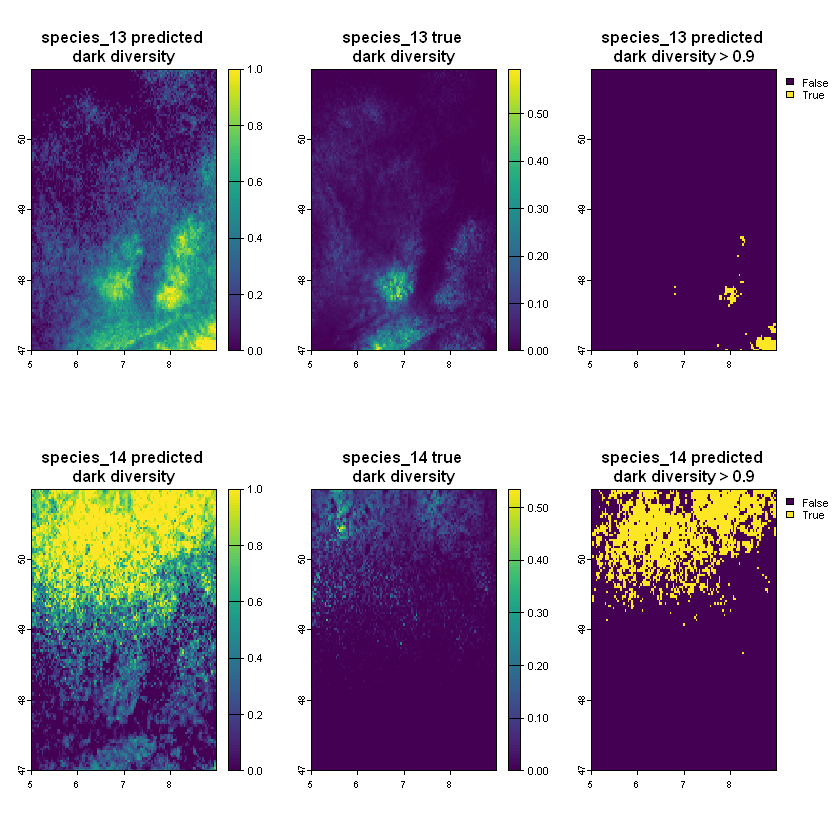

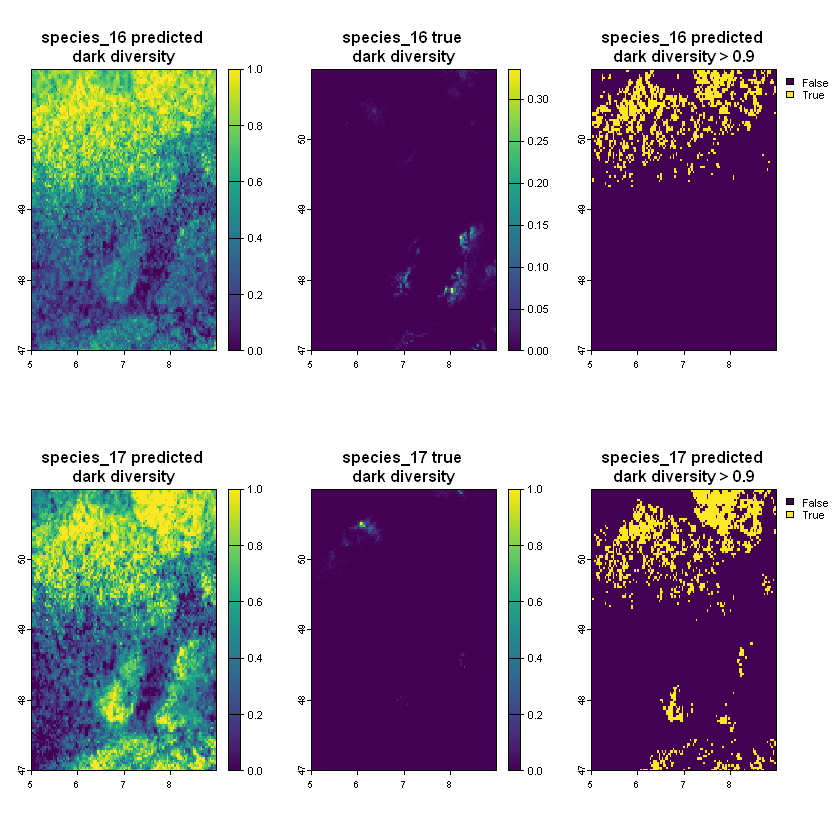

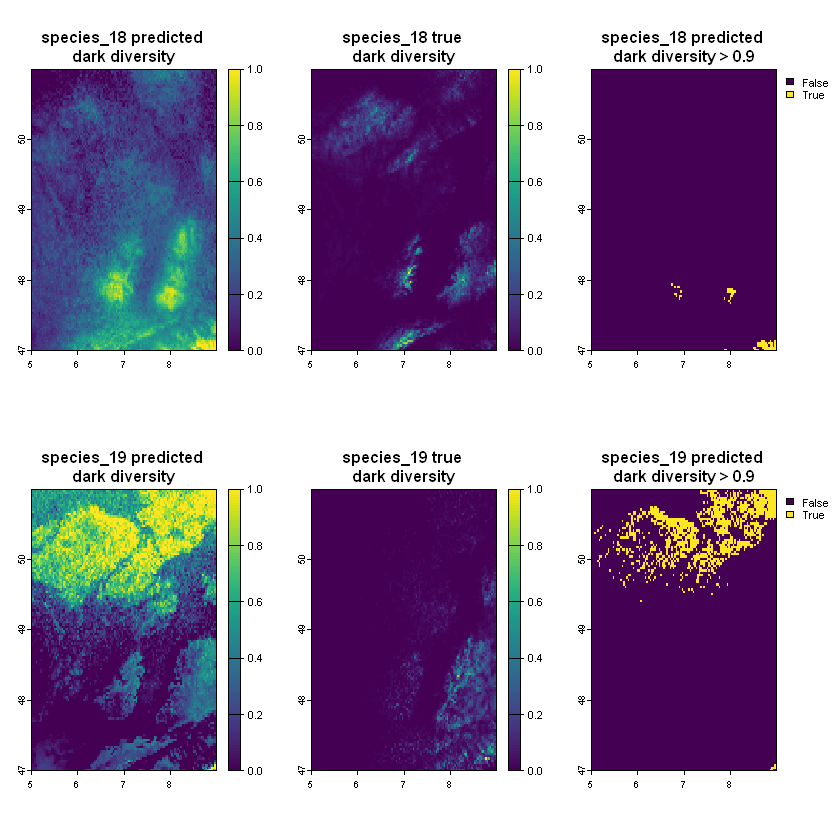

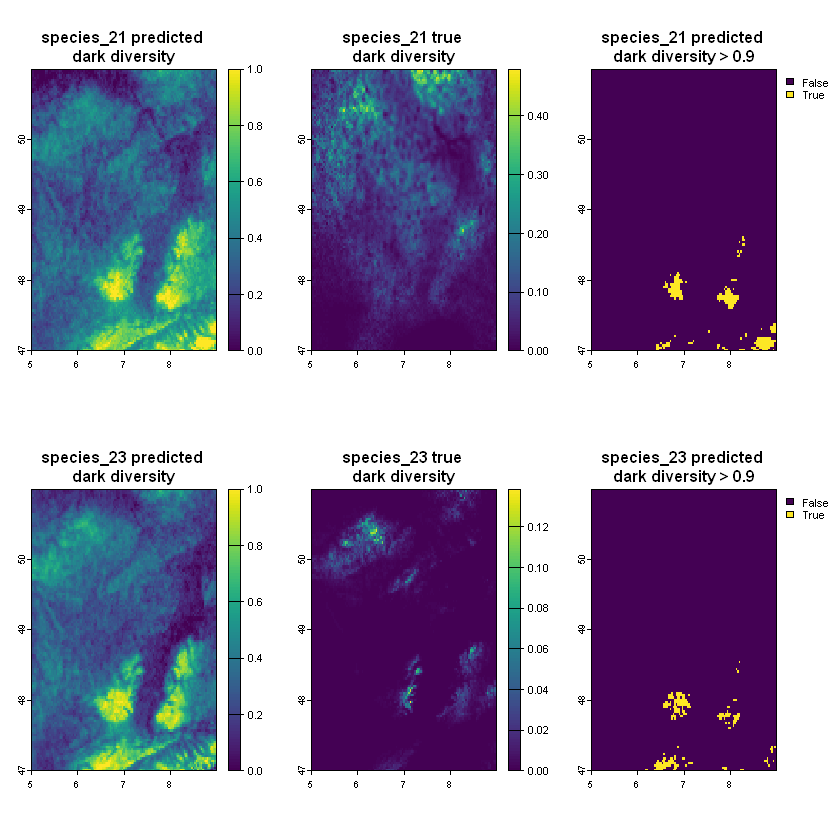

In [12]:
# dark_mod_a_gam <- gamm4::gamm4(species_1 ~ s(env_1) + s(env_2) + s(env_4) + s(env_5) + s(env_6), data = full_obs)
par(bg = "white", mfrow = c(2, 3))

pred_dark_list <- c()
for (i in 1:length(colnames(dark_div_zerofilled))) {
    tryCatch({
        gam_mod <- gamm4::gamm4(
            as.formula(
                paste0(
                    colnames(dark_div_zerofilled)[i], " ~ s(env_1) + s(env_2) + s(env_4) + s(env_5) + s(env_6)"
                )
            ),
            data = full_obs
        )
        gam_pred <- predict(envs, gam_mod$gam, type = "response") |>
            terra::clamp(0, 1)
        names(gam_pred) <- colnames(dark_div_zerofilled)[i]
        pred_dark_list <- c(pred_dark_list, gam_pred)
        plot(gam_pred, main = paste0(colnames(dark_div_zerofilled)[i], " predicted \ndark diversity"))
        plot(dark_dist_stack[[i]], main = paste0(colnames(dark_div_zerofilled)[i], " true \ndark diversity"))
        plot(gam_pred > 0.9, main = paste0(colnames(dark_div_zerofilled)[i], " predicted \ndark diversity > 0.9"))
    }, error = function(e) {
        cat("Error for species", colnames(dark_div_zerofilled)[i], ":", conditionMessage(e), "\n")
    })
}

pred_dark_stack <- terra::rast(pred_dark_list)


# 6. Quantifying the performance

How well does the modelled dark diversity correlate with the actual? We will calculate the correlation between the modelled and actual dark diversity across the study area.

In [13]:
dark_dist_values <- values(dark_dist_stack)
pred_dark_values <- values(pred_dark_stack)

matched <- which(
    colnames(dark_dist_values) %in% colnames(pred_dark_values),
    arr.ind = TRUE
)

matched_dark_dist_values <- dark_dist_values[, matched]

cor_score <- c()
for (i in 1:ncol(matched_dark_dist_values)) {
    cor_score <- c(cor_score, cor(matched_dark_dist_values[, i], pred_dark_values[, i]))
}

# dark_cov_df$cor_score <- cor_score
# dark_cov_df
dark_cor_df <- data.frame(
    species = colnames(matched_dark_dist_values),
    cor_score = cor_score
)
left_join(dark_cov_df, dark_cor_df, by = "species")

mean(cor_score)

species,dark_cov_applied,cor_score
<chr>,<int>,<dbl>
species_1,3,0.55488225
species_2,3,0.50629935
species_3,2,0.75136748
species_4,2,0.06559346
species_5,0,0.15572310
species_6,3,0.77316860
species_7,0,0.22170592
species_8,3,0.14213542
species_9,3,0.69200957


[1] 0.4161378

In [14]:
# pred_dark_values[, 1]
# colnames(pred_dark_values)[1]

pred_col <- data.frame()
for (i in 1:ncol(pred_dark_values)) {
    x <- data.frame(
        pred_dark_values[, i],
        colnames(pred_dark_values)[i]
    )
    pred_col <- rbind(pred_col, x)
}
colnames(pred_col) <- c("predicted", "species")

matched_col <- data.frame()
for (i in 1:ncol(matched_dark_dist_values)) {
    x <- data.frame(
        scales::rescale(matched_dark_dist_values[, i])
    )
    matched_col <- rbind(matched_col, x)
}
colnames(matched_col) <- c("true")

matched_longer <- cbind(pred_col, matched_col)

head(matched_longer)

,predicted,species,true
,<dbl>,<chr>,<dbl>
1,0,species_1,1.814403e-04
2,0,species_1,8.266349e-06
3,0,species_1,5.441915e-05
4,0,species_1,2.301217e-05
5,0,species_1,4.091929e-05
6,0,species_1,5.252093e-05


In [15]:
matched_longer$species <- as.factor(matched_longer$species)

# Fit a linear model for each species
model <- lme4::lmer(predicted ~ true + (1 | species), data = matched_longer)

# # Print the model summary
summary(model)

model_sqrt <- lme4::lmer(predicted ~ sqrt(true) + (1 | species), data = matched_longer)
summary(model_sqrt)

anova(model, model_sqrt)

Linear mixed model fit by REML ['lmerMod']
Formula: predicted ~ true + (1 | species)
   Data: matched_longer

REML criterion at convergence: 10036.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.6198 -0.6965 -0.1336  0.6100  3.8686 

Random effects:
 Groups   Name        Variance Std.Dev.
 species  (Intercept) 0.02746  0.1657  
 Residual             0.06059  0.2461  
Number of obs: 288000, groups:  species, 20

Fixed effects:
            Estimate Std. Error t value
(Intercept) 0.308712   0.037061    8.33
true        1.465419   0.005213  281.11

Correlation of Fixed Effects:
     (Intr)
true -0.007

Linear mixed model fit by REML ['lmerMod']
Formula: predicted ~ sqrt(true) + (1 | species)
   Data: matched_longer

REML criterion at convergence: -29996.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.3459 -0.7041 -0.0987  0.6482  4.7340 

Random effects:
 Groups   Name        Variance Std.Dev.
 species  (Intercept) 0.03888  0.1972  
 Residual             0.05272  0.2296  
Number of obs: 288000, groups:  species, 20

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.21665    0.04410   4.913
sqrt(true)   1.14826    0.00314 365.736

Correlation of Fixed Effects:
           (Intr)
sqrt(true) -0.010

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
model,4,10031.02,10073.30,-5011.51,10023.02,NA,NA,NA
model_sqrt,4,-30002.73,-29960.45,15005.37,-30010.73,40033.75,0,NA


In [16]:
lm_mod <- lm(predicted ~ true * species, data = matched_longer)
summary(lm_mod)

lm_mod_sqrt <- lm(predicted ~ sqrt(true) * species, data = matched_longer)
summary(lm_mod_sqrt)

anova(lm_mod, lm_mod_sqrt)


Call:
lm(formula = predicted ~ true * species, data = matched_longer)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.00693 -0.16571 -0.02507  0.14411  0.95531 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             0.249675   0.002098 119.029  < 2e-16 ***
true                    1.929969   0.024886  77.552  < 2e-16 ***
speciesspecies_10       0.216653   0.003143  68.937  < 2e-16 ***
speciesspecies_11       0.274703   0.003013  91.179  < 2e-16 ***
speciesspecies_12      -0.229851   0.003109 -73.929  < 2e-16 ***
speciesspecies_13      -0.088338   0.003204 -27.574  < 2e-16 ***
speciesspecies_14       0.064263   0.003090  20.797  < 2e-16 ***
speciesspecies_16       0.231896   0.002902  79.923  < 2e-16 ***
speciesspecies_17       0.249529   0.003044  81.978  < 2e-16 ***
speciesspecies_18      -0.001959   0.003007  -0.652  0.51470    
speciesspecies_19      -0.124473   0.003687 -33.757  < 2e-16 ***
speciesspecies_2        0.0649


Call:
lm(formula = predicted ~ sqrt(true) * species, data = matched_longer)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.77171 -0.14334 -0.01754  0.11986  1.10206 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   0.156781   0.002221  70.585  < 2e-16 ***
sqrt(true)                    1.533135   0.013741 111.577  < 2e-16 ***
speciesspecies_10             0.207566   0.003831  54.185  < 2e-16 ***
speciesspecies_11             0.259316   0.003274  79.195  < 2e-16 ***
speciesspecies_12            -0.139246   0.003359 -41.449  < 2e-16 ***
speciesspecies_13            -0.111258   0.003951 -28.158  < 2e-16 ***
speciesspecies_14             0.028550   0.003245   8.797  < 2e-16 ***
speciesspecies_16             0.295777   0.002927 101.048  < 2e-16 ***
speciesspecies_17             0.259791   0.003391  76.611  < 2e-16 ***
speciesspecies_18             0.044468   0.003182  13.974  < 2e-16 ***
speciesspecies_19      

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,287960,16491.29,NA,NA,NA,NA
2,287960,13615.48,0,2875.816,NA,NA


In [17]:
glm_mod <- glm(predicted ~ true * species, data = matched_longer, family = binomial(link = logit))

summary(glm_mod)

Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = predicted ~ true * species, family = binomial(link = logit), 
    data = matched_longer)

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -1.20510    0.02132 -56.528  < 2e-16 ***
true                    16.42096    0.57147  28.735  < 2e-16 ***
speciesspecies_10        0.99746    0.03016  33.072  < 2e-16 ***
speciesspecies_11        0.91453    0.03050  29.983  < 2e-16 ***
speciesspecies_12       -2.67841    0.06929 -38.657  < 2e-16 ***
speciesspecies_13       -0.38572    0.03365 -11.462  < 2e-16 ***
speciesspecies_14       -0.01029    0.03239  -0.318 0.750608    
speciesspecies_16        1.07633    0.02743  39.232  < 2e-16 ***
speciesspecies_17        1.18981    0.02842  41.867  < 2e-16 ***
speciesspecies_18        0.09855    0.02973   3.315 0.000917 ***
speciesspecies_19       -0.61016    0.03977 -15.342  < 2e-16 ***
speciesspecies_2         0.31363    0.02874  10.914  < 2e-16 ***
speciesspecies_21        0.617

`geom_smooth()` using method = 'gam'
Warning message:
"Removed 2172 rows containing non-finite outside the scale range
(`stat_smooth()`)."


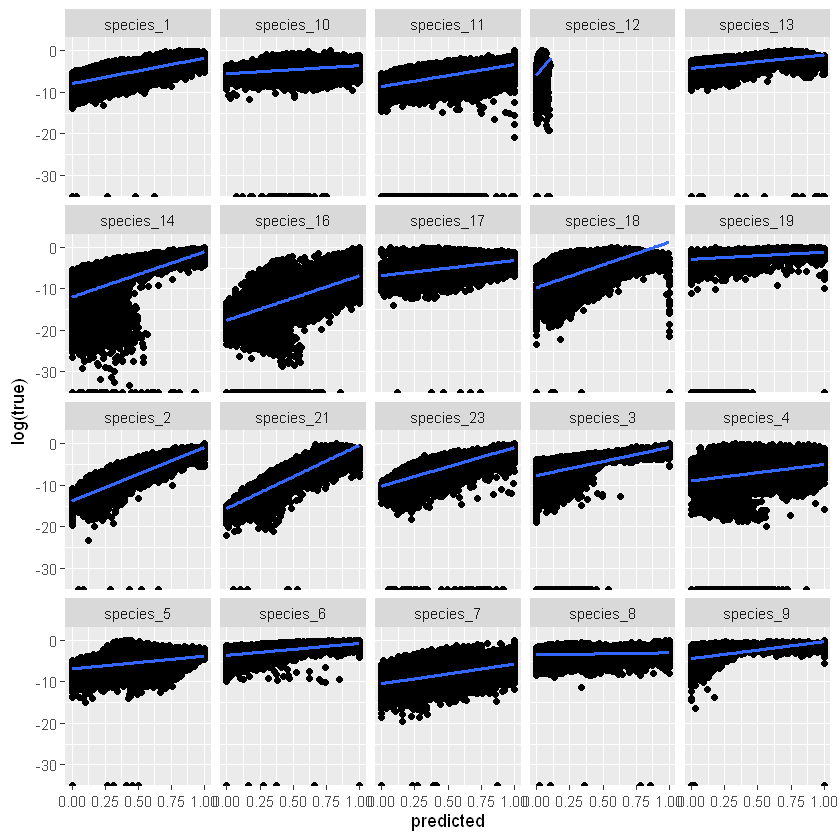

In [18]:
ggplot(matched_longer, aes(x = predicted, y = log(true))) +
    geom_point() +
    geom_smooth(formula = y ~ x) +
    facet_wrap(~species)

From these correlation scores, we can see that in general there is a positive correlation between the modelled and actual dark diversity. However, the correlation is far from the idea 1:1 relationship, indicating that the method is not able to fully capture the dark diversity.

For some species e.g. 9, the relationships is much better, especially spatially. However, this is not consistent across all the similuated species, and so it is difficult to conclusively say that the method is effective.

The mean correlation coefficient across all species is only 0.416, which is not very high. There is also a large amount of variable across species, with species 6 having the highest correlation at 0.77, and species 4 having the lowest at 0.07.